[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Cointegrated pairs: [('C', 'USB'), ('BAC', 'PNC')]


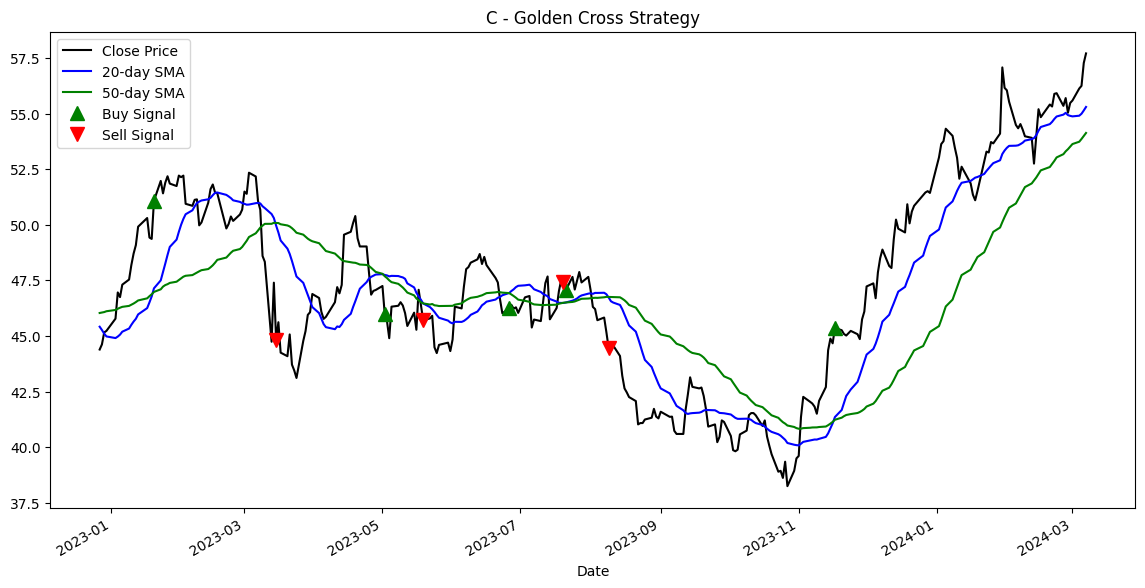

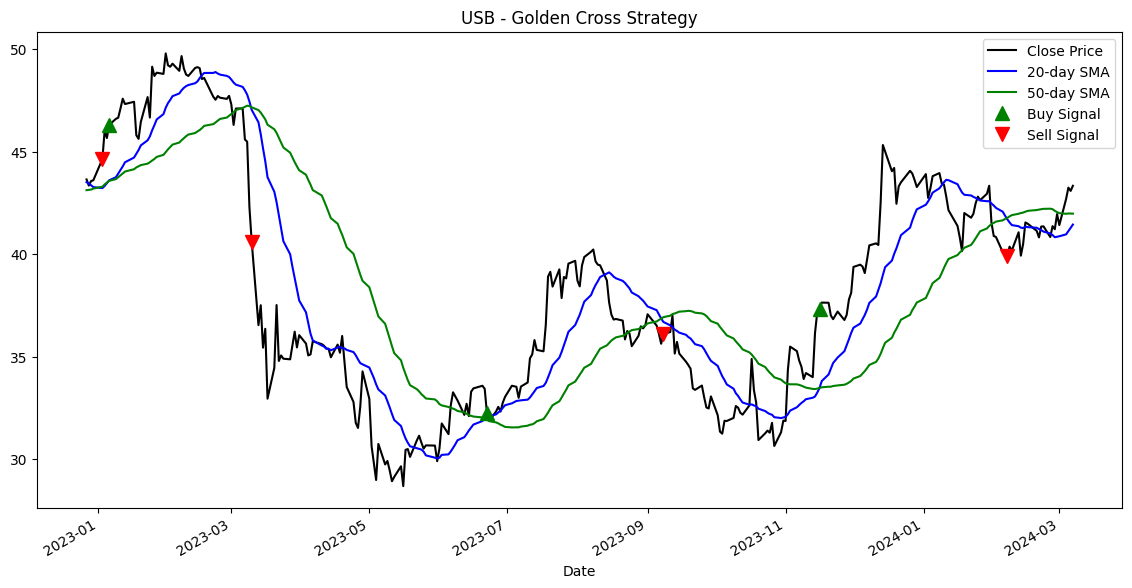

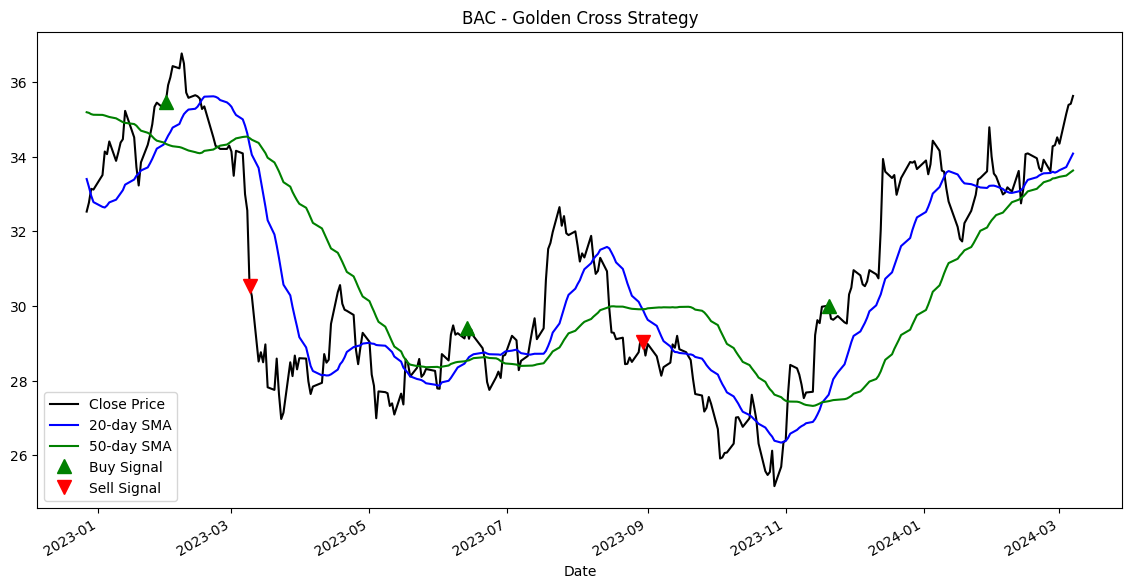

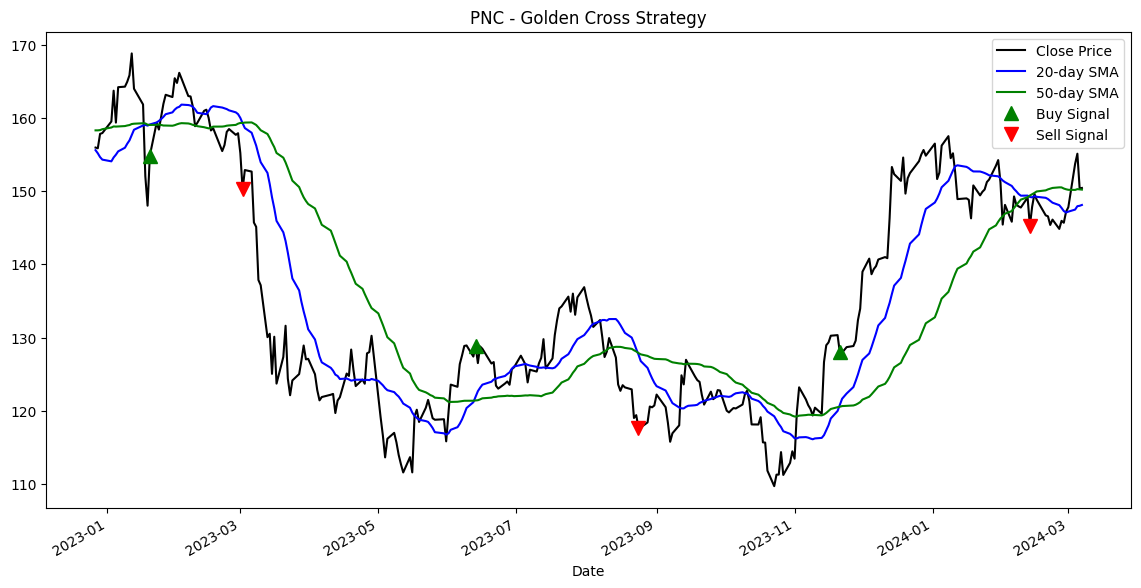

Backtesting Report:
--------------------------------------------------------------------------------
Pair                 Ann. Return          Ann. Volatility      Sharpe Ratio         Max Drawdown        
--------------------------------------------------------------------------------
C - USB              -1.00                0.23                 -4.43                7.34                
BAC - PNC            -1.00                0.18                 -5.63                0.00                
--------------------------------------------------------------------------------


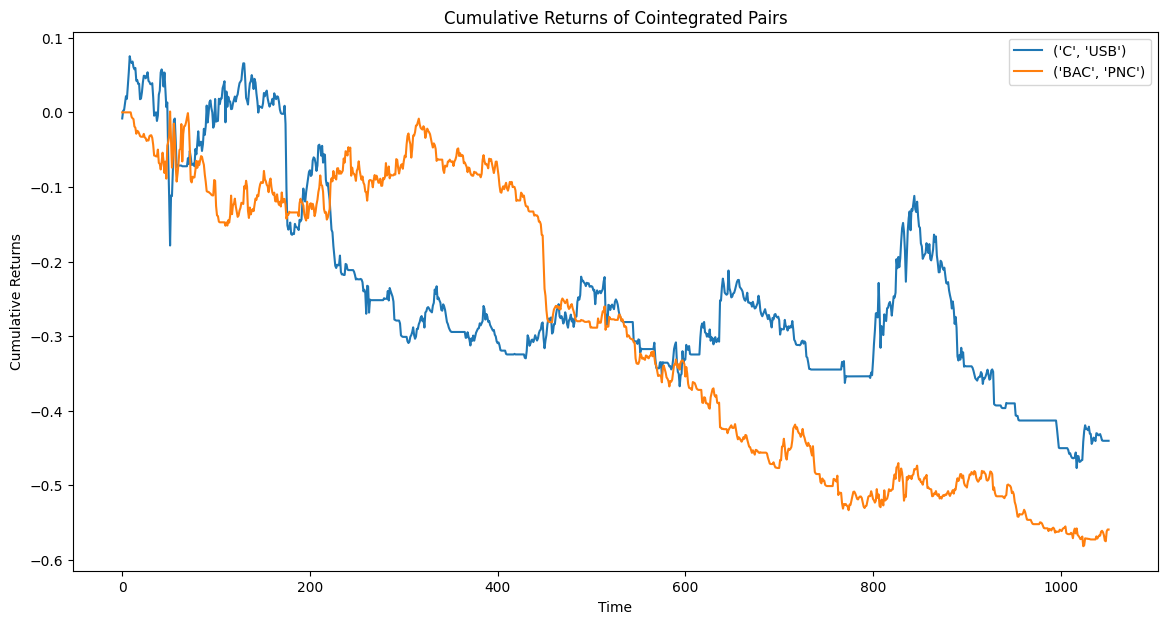

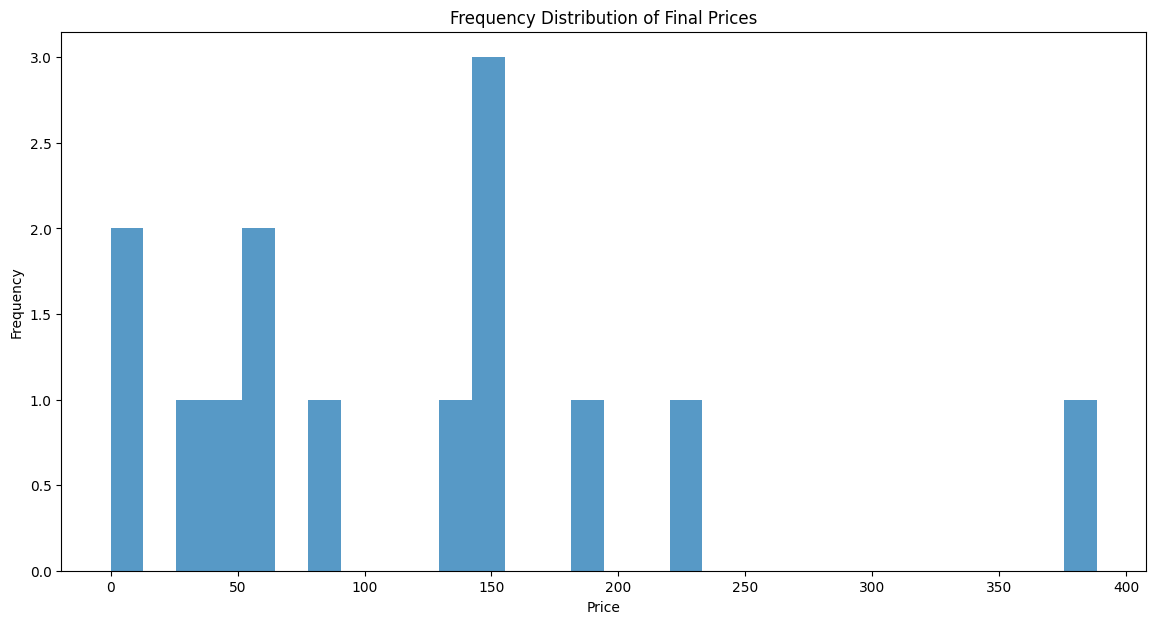

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Parameters
universe = ['JPM', 'C', 'GS', 'MS', 'BAC', 'WFC', 'USB', 'AXP', 'COF', 'PNC']  # Expanded universe of stocks
start = '2019-01-01'  # Extended start date
end = '2024-03-08'
fee = 0.001
window = 252
t_threshold = -2.5
coint_threshold = 0.1  # Increased p-value threshold for cointegration
spread_threshold = 1.5  # Threshold for spread between prices of two assets

# Fetch data
data = pd.DataFrame()
for stock in universe:
    prices = yf.download(stock, start, end)
    if 'Close' in prices.columns:
        data[stock] = prices['Close']
    else:
        print(f"Data for {stock} not available")

# Data Preprocessing
# Remove rows with missing values (if any)
data.dropna(inplace=True)

# Function to find cointegrated pairs
def find_cointegrated_pairs(data, coint_threshold):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < coint_threshold:
                pairs.append((keys[i], keys[j]))
    
    return score_matrix, pvalue_matrix, pairs

# Function to generate Golden Cross signals and plot
def GoldenCrossoverSignal(data, stock, data_point=300):
    data['20_SMA'] = data[stock].rolling(window=20, min_periods=1).mean()
    data['50_SMA'] = data[stock].rolling(window=50, min_periods=1).mean()
    data['Signal'] = np.where(data['20_SMA'] > data['50_SMA'], 1, 0)
    data['Position'] = data['Signal'].diff()
    
    # Plot the signal generation
    plt.figure(figsize=(14, 7))
    data[-data_point:][stock].plot(color='k', label='Close Price')
    data[-data_point:]['20_SMA'].plot(color='b', label='20-day SMA')
    data[-data_point:]['50_SMA'].plot(color='g', label='50-day SMA')
    plt.plot(data[-data_point:][data[-data_point:]['Position'] == 1].index, 
             data[-data_point:][stock][data[-data_point:]['Position'] == 1], 
             '^', markersize=10, color='g', label='Buy Signal')
    plt.plot(data[-data_point:][data[-data_point:]['Position'] == -1].index, 
             data[-data_point:][stock][data[-data_point:]['Position'] == -1], 
             'v', markersize=10, color='r', label='Sell Signal')
    plt.title(f'{stock} - Golden Cross Strategy')
    plt.legend()
    plt.show()
    
    return data

# Backtesting function
def backtest_pair(data, stock1, stock2, fee, window, t_threshold, spread_threshold):
    returns = pd.DataFrame()
    returns[stock1] = np.append(data[stock1][1:].reset_index(drop=True) / data[stock1][:-1].reset_index(drop=True) - 1, 0)
    returns[stock2] = np.append(data[stock2][1:].reset_index(drop=True) / data[stock2][:-1].reset_index(drop=True) - 1, 0)
    
    gross_returns = np.array([])
    net_returns = np.array([])
    signals = np.array([])
    spread_values = np.array([])
    
    for t in range(window, len(data)):
        S1 = data[stock1][t-window:t]
        S2 = data[stock2][t-window:t]
        
        # Estimate cointegration parameters
        res = sm.OLS(S2, sm.add_constant(S1)).fit()
        beta = res.params.iloc[1]
        alpha = res.params.iloc[0]
        
        # Calculate spread and generate signals
        spread = S2 - beta * S1 - alpha
        spread_values = np.append(spread_values, spread.iloc[-1])  # Record the last spread value
        
        # Adjust condition to prevent IndexError
        if spread.iloc[-1] < -spread_threshold:
            signal = 1  # Buy S1, Sell S2
        elif spread.iloc[-1] > spread_threshold:
            signal = -1  # Sell S1, Buy S2
        else:
            signal = 0  # No action
        
        # Calculate returns and fees
        if t == window:
            old_signal = 0
        
        gross_return = signal * (returns[stock1][t] - returns[stock2][t])
        fees = fee * abs(signal - old_signal)
        net_return = gross_return - fees
        
        # Record results
        gross_returns = np.append(gross_returns, gross_return)
        net_returns = np.append(net_returns, net_return)
        signals = np.append(signals, signal)
        
        old_signal = signal
    
    return gross_returns, net_returns, signals, spread_values

# Calculate maximum drawdown
def calculate_max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns) - 1
    running_max = np.maximum.accumulate(cumulative_returns)
    
    # Check for cases where running_max is zero to avoid division by zero
    if np.any(running_max == 0):
        drawdowns = np.zeros_like(cumulative_returns)
    else:
        drawdowns = (running_max - cumulative_returns) / running_max
    
    max_drawdown = np.nanmax(drawdowns)  # Use np.nanmax to ignore NaN values
    
    return max_drawdown

# Run data preprocessing
data = data.dropna()

# Find cointegrated pairs
scores, pvalues, pairs = find_cointegrated_pairs(data, coint_threshold)
print(f"Cointegrated pairs: {pairs}")

# Run backtests for all cointegrated pairs
results = {}
for pair in pairs:
    stock1, stock2 = pair
    
    # Generate signals and plot for each stock in the pair
    data = GoldenCrossoverSignal(data, stock1)
    data = GoldenCrossoverSignal(data, stock2)
    
    gross_returns, net_returns, signals, spread_values = backtest_pair(data, stock1, stock2, fee, window, t_threshold, spread_threshold)
    max_drawdown = calculate_max_drawdown(net_returns)
    results[pair] = {
        'gross_returns': gross_returns,
        'net_returns': net_returns,
        'signals': signals,
        'spread_values': spread_values,
        'max_drawdown': max_drawdown
    }

# Evaluate performance
# Evaluate performance
def generate_backtesting_report(pairs, results):
    report = []
    for pair, result in results.items():
        net_returns = result['net_returns']
        cumulative_returns = np.cumprod(1 + net_returns) - 1
        annualized_return = np.prod(1 + cumulative_returns)**(252/len(cumulative_returns)) - 1
        annualized_volatility = np.std(net_returns) * np.sqrt(252)
        sharpe_ratio = annualized_return / annualized_volatility
        max_drawdown = calculate_max_drawdown(net_returns)
        cumulative_return = cumulative_returns[-1]
        
        metrics = {
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown
        }
        
        report.append((pair, metrics, cumulative_return))
    
    # Print the backtesting report
    print("Backtesting Report:")
    print("-" * 80)
    print("{:<20} {:<20} {:<20} {:<20} {:<20}".format("Pair", "Ann. Return", "Ann. Volatility", "Sharpe Ratio", "Max Drawdown"))
    print("-" * 80)
    for pair, metrics, cumulative_return in report:
        print("{:<20} {:<20.2f} {:<20.2f} {:<20.2f} {:<20.2f}".format(
            pair[0] + " - " + pair[1],
            metrics['Annualized Return'],
            metrics['Annualized Volatility'],
            metrics['Sharpe Ratio'],
            metrics['Max Drawdown']
        ))
    print("-" * 80)

# Generate and print the backtesting report
generate_backtesting_report(pairs, results)
# Plot cumulative returns
def plot_cumulative_returns(results):
    plt.figure(figsize=(14, 7))
    for pair, result in results.items():
        cumulative_returns = np.cumprod(1 + result['net_returns']) - 1
        plt.plot(cumulative_returns, label=f'{pair}')
    plt.title('Cumulative Returns of Cointegrated Pairs')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

plot_cumulative_returns(results)

# Plot frequency distribution of final prices
def plot_price_distribution(data, universe):
    plt.figure(figsize=(14, 7))
    final_prices = data.iloc[-1]
    plt.hist(final_prices, bins=30, alpha=0.75)
    plt.title('Frequency Distribution of Final Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

plot_price_distribution(data, universe)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9084\3297889083.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res1 = spop.minimize(unit_root, data[stock2][t] / data[stock1][t], method='Nelder-Mead')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9084\3297889083.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_opt = float(res1.x)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9084\3297889083.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version,

Day: 2020-12-30 00:00:00
 
No trading
Gross daily return: 0%
Net daily return: 0.0%
Cumulative net return so far: 0.0%

Day: 2020-12-31 00:00:00
 
No trading
Gross daily return: 0%
Net daily return: 0.0%
Cumulative net return so far: 0.0%

Day: 2021-01-04 00:00:00
 
No trading
Gross daily return: 0%
Net daily return: 0.0%
Cumulative net return so far: 0.0%

Day: 2021-01-05 00:00:00
 
No trading
Gross daily return: 0%
Net daily return: 0.0%
Cumulative net return so far: 0.0%

Day: 2021-01-06 00:00:00
 
No trading
Gross daily return: 0%
Net daily return: 0.0%
Cumulative net return so far: 0.0%

Day: 2021-01-07 00:00:00
 
No trading
Gross daily return: 0%
Net daily return: 0.0%
Cumulative net return so far: 0.0%

Day: 2021-01-08 00:00:00
 
No trading
Gross daily return: 0%
Net daily return: 0.0%
Cumulative net return so far: 0.0%

Day: 2021-01-11 00:00:00
 
No trading
Gross daily return: 0%
Net daily return: 0.0%
Cumulative net return so far: 0.0%

Day: 2021-01-12 00:00:00
 
Long position

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9084\3297889083.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  signal = np.sign(fair_value - data[stock2][t])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9084\3297889083.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gross_return = signal * returns[stock2][t] - signal * returns[stock1][t]


Day: 2021-01-15 00:00:00
 
Long position on C and short position on JPM
Gross daily return: -5.13%
Net daily return: -5.33%
Cumulative net return so far: -6.97%

Day: 2021-01-19 00:00:00
 
Long position on JPM and short position on C
Gross daily return: 0.41%
Net daily return: 0.21%
Cumulative net return so far: -6.77%

Day: 2021-01-20 00:00:00
 
Long position on JPM and short position on C
Gross daily return: -0.81%
Net daily return: -0.81%
Cumulative net return so far: -7.53%

Day: 2021-01-21 00:00:00
 
Long position on C and short position on JPM
Gross daily return: -1.34%
Net daily return: -1.54%
Cumulative net return so far: -8.95%

Day: 2021-01-22 00:00:00
 
Long position on JPM and short position on C
Gross daily return: 0.1%
Net daily return: -0.1%
Cumulative net return so far: -9.04%

Day: 2021-01-25 00:00:00
 
Long position on C and short position on JPM
Gross daily return: -0.01%
Net daily return: -0.21%
Cumulative net return so far: -9.23%

Day: 2021-01-26 00:00:00
 
Long p

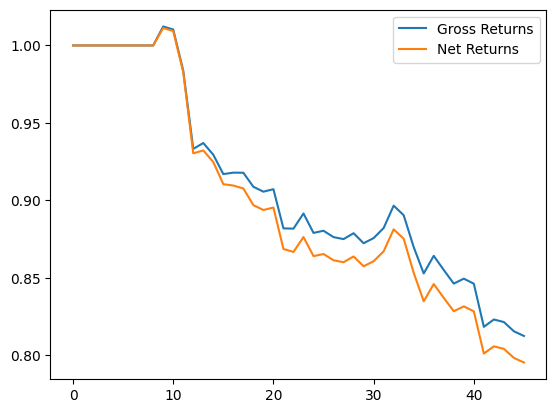

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as spop

# Parameters
stocks = ['JPM', 'C']
start = '2019-12-31'
end = '2021-03-08'
fee = 0.001
window = 252
t_threshold = -2.5

# Fetch data and calculate returns
data = pd.DataFrame()
returns = pd.DataFrame()

for stock in stocks:
    try:
        prices = yf.download(stock, start, end)
        data[stock] = prices['Close']
        returns[stock] = data[stock].pct_change().fillna(0)
    except Exception as e:
        print(f"Failed to download data for {stock}: {e}")

# Ensure that returns DataFrame aligns with data DataFrame
assert len(returns) == len(data)

# Initialize variables
gross_returns = np.array([])
net_returns = np.array([])
t_s = []
stock1 = stocks[0]
stock2 = stocks[1]

# Trading strategy
for t in range(window, len(data)):
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b * data[stock1][t-window:t])
        fair_value = a + b * data[stock1][t-window:t]
        diff = np.array(fair_value - data[stock2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0] / res.bse[0]

    res1 = spop.minimize(unit_root, data[stock2][t] / data[stock1][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt * data[stock1][t-window:t])
    fair_value = a_opt + b_opt * data[stock1][t]
    
    if t == window:
        old_signal = 0
    
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[stock2][t])
        gross_return = signal * returns[stock2][t] - signal * returns[stock1][t]
    
    fees = fee * abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    
    print('Day: ' + str(data.index[t]))
    print(' ')
    if signal == 0:
        print('No trading')
    elif signal == 1:
        print('Long position on ' + stock2 + ' and short position on ' + stock1)
    else:
        print('Long position on ' + stock1 + ' and short position on ' + stock2)
    
    print('Gross daily return: ' + str(round(gross_return * 100, 2)) + '%')
    print('Net daily return: ' + str(round(net_return * 100, 2)) + '%')
    print('Cumulative net return so far: ' + str(round(np.prod(1 + net_returns) * 100 - 100, 2)) + '%')
    print('')
    
    old_signal = signal

# Plot results
plt.plot(np.append(1, np.cumprod(1 + gross_returns)), label='Gross Returns')
plt.plot(np.append(1, np.cumprod(1 + net_returns)), label='Net Returns')
plt.legend()
plt.show()



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9084\3514242587.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif abs(raw_data[tickers[1]][t] / (a_opt + b_opt * raw_data[tickers[0]][t]) - 1) < entry:
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9084\3514242587.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gross = position0 * (raw_data[tickers[0]][t+1] / raw_data[tickers[0]][t] - 1) + \
C:\Users\ASUS\AppDa

Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered
Stop-loss triggered


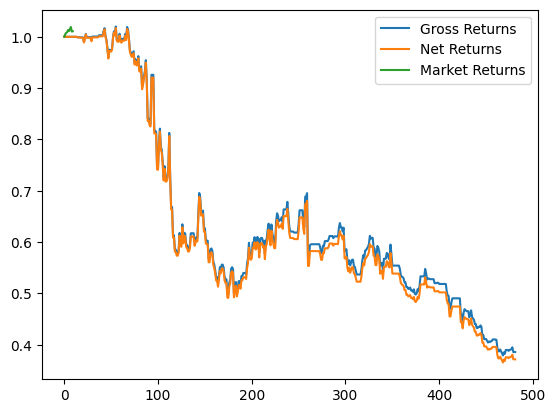

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as spop

# Specifying rolling window length
window = 21

# Specifying maximum KPSS statistic (95% critical value)
KPSS_max = 0.463

# Specifying whether to perform beta-loading or not 
beta_loading = 0

# Strategy parameters - trading fee, optimal entry (divergence), and stop-loss
fee = 0.0001
entry = 0.02
stop_loss = -0.05

# Initially start in cash
signal = 0
current_return = 0
position0 = 0
position1 = 0

# Specifying the sample
start = '2019-09-28'
end = '2021-09-28'
tickers = ['JPM', 'AMZN']
market = '^NSEI'

gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()

# Downloading data
for ticker in tickers:
    raw_data[ticker] = yf.download(ticker, start, end)['Close']
raw_data[market] = yf.download(market, start, end)['Close']

# Backtesting
for t in range(window, len(raw_data) - 1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    
    data = raw_data[t-window:t]
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    
    if beta_loading == 1:
        def KPSS(b):
            a = np.average(data[tickers[1]] - b * data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b * data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2) / (len(resid) - 1))**(1/2)
            KPSS = np.sum(cum_resid**2) / (len(resid)**2 * st_error**2)
            return KPSS
        
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt * data[tickers[0]])
    else:
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b * data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2) / (len(resid) - 2))**(1/2)
            KPSS = np.sum(cum_resid**2) / (len(resid)**2 * st_error**2)
            return KPSS
        
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    
    if current_return < stop_loss:
        signal = 0
        print('Stop-loss triggered')
    elif abs(raw_data[tickers[1]][t] / (a_opt + b_opt * raw_data[tickers[0]][t]) - 1) < entry:
        signal = 0
    else:
        if KPSS_opt > KPSS_max:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt * raw_data[tickers[0]][t]))
    
    if beta_loading == 1:
        rets0 = np.array(data[tickers[0]]) / np.array(data[tickers[0]].shift(1)) - 1
        rets1 = np.array(data[tickers[1]]) / np.array(data[tickers[1]].shift(1)) - 1
        rets_mkt = np.array(data[market]) / np.array(data[market].shift(1)) - 1
        
        reg0 = sm.OLS(rets0[1:], sm.add_constant(rets_mkt[1:]))
        res0 = reg0.fit()
        beta0 = res0.params[1]
        
        reg1 = sm.OLS(rets1[1:], sm.add_constant(rets_mkt[1:]))
        res1 = reg1.fit()
        beta1 = res1.params[1]
        
        position0 = beta1 * signal
        position1 = -beta0 * signal
    else:
        position0 = signal
        position1 = -signal
    
    gross = position0 * (raw_data[tickers[0]][t+1] / raw_data[tickers[0]][t] - 1) + \
            position1 * (raw_data[tickers[1]][t+1] / raw_data[tickers[1]][t] - 1)
    net = gross - fee * (abs(position0 - old_position0) + abs(position1 - old_position1))
    market_ret = raw_data[market][t+1] / raw_data[market][t] - 1
    
    if signal == old_signal:
        current_return = (1 + current_return) * (1 + gross) - 1
    else:
        current_return = gross
    
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market_ret)

output = pd.DataFrame({
    'KPSS': KPSS_stats,
    'gross': gross_returns,
    'net': net_returns,
    'market': market_returns
})

plt.plot(np.append(1, np.cumprod(1 + gross_returns)), label='Gross Returns')
plt.plot(np.append(1, np.cumprod(1 + net_returns)), label='Net Returns')
plt.plot(np.append(1, np.cumprod(1 + market_returns)), label='Market Returns')
plt.legend()
plt.show()

